# Full Run of Model

In this notebook I run all model functionalities on dummy dataset.

In [1]:
import torch

from data import DummyDataset, DummyDatasetConfig
from model import HeirarchicalTransformer, HeirarchicalTransformerConfig

from train import *

from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import trange

In [2]:
dataConfig = DummyDatasetConfig(
    n_samples = 1000,
    n_nodes = 30,
    n_features = 5,
    maxlen = 12,
    seqlen = 6
)
wd = DummyDataset(dataConfig)

In [3]:
for x in DataLoader(wd, batch_size = 32, shuffle = True):
    print({k:(v.size(), v.dtype) for k,v in x.items()})
    break

{'input': (torch.Size([32, 2, 6, 30, 5]), torch.float32), 'node_mask': (torch.Size([32, 2, 6, 30]), torch.int64), 'month_ids': (torch.Size([32, 2, 6]), torch.int64), 'day_ids': (torch.Size([32, 2, 6]), torch.int64), 'hour_ids': (torch.Size([32, 2, 6]), torch.int64)}


In [4]:
modelConf = HeirarchicalTransformerConfig(
    n_embd=dataConfig.n_features * 3,
    n_global=12,
    maxlen=dataConfig.seqlen,
    n_head=3,
    n_layer=1,
    num_nodes=dataConfig.n_nodes,
    num_features=dataConfig.n_features,
    location_features=3
)

In [5]:
model = HeirarchicalTransformer(modelConf)

In [6]:
model.num_params, len([1 for _ in enumerate(model.parameters())])

(8757, 56)

In [7]:
trainConf = TrainerConfig(learning_rate = 0.0001, len_data = len(wd), batch_size = 32, weight_decay = 0.1)
optim = model.configure_optimizers(train_config = trainConf)

In [8]:
for e in range(10):
    pbar = trange((len(wd) // 32) + 1)
    for _, x in zip(pbar, DataLoader(wd, batch_size = 32, shuffle = True)):
        for i in range(x["input"].size(1)):
            in_data = {k:v[:,i,...] for k,v in x.items()}

            logits, mems, loss = model(**in_data, edge_matrix = wd.edge_mat, locations = wd.loc_mat, get_loss = True)
            pbar.set_description(f"E{e}; S{i}; L:{loss.item():.3f}")
            loss.backward()
            optim.step()
            
#             # if you just want to run inference
#             logits, mems = model(**in_data, edge_matrix = wd.edge_mat, locations = wd.loc_mat)
#             print(logits.size(), len(mems))

/Users/yashbonde/Desktop/AI/vv2/optimizer.py:142: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  grad.add_(group['weight_decay'], p.data)


KeyboardInterrupt: 

### Attention Mask

Below you can see what an attention mask would look like.

In [40]:
nm = x["node_mask"]
mask = torch.zeros(*list(nm.size()), list(nm.size())[-1])
for i in range(nm.size(0)):
    for j in range(nm.size(1)):
        idx = torch.masked_select(
            torch.arange(len(nm[i, j])),
            nm[i, j] == 0
        ).tolist()
        if idx:
            for k in idx:
                mask[i,j,k] = 1e-6
                mask[i,j,:,k] = 1e-6

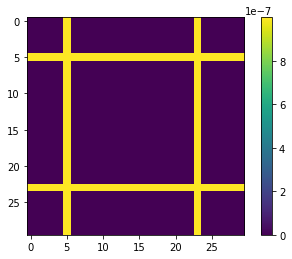

In [44]:
plt.imshow(mask[31, 3].tolist())
plt.colorbar()

### Pooling

Pooling used for node to global embedding is a bit tricky to build.

In [72]:
from torch.nn import MaxPool1d, MaxUnpool1d
import torch.nn.functional as F

class ChannelPool(MaxPool1d):
    def forward(self, input):
        n, w, c, h = input.size()
        input = input.view(n*w,c,h).permute(0, 2, 1)
        pooled =  F.max_pool1d(input, self.kernel_size, self.stride,
                        self.padding, self.dilation, self.ceil_mode,
                        self.return_indices)
        _, _, c = pooled.size()
        pooled = pooled.permute(0,2,1)
        return pooled.view(n,c,w,h).squeeze(1)

In [83]:
# this is the node to global pooling
p = ChannelPool(5)

x = torch.randn(2, 2, 5, 3)
print(x)
print()
y = p(x)
print(y)
print(y.size())

tensor([[[[-0.3946,  1.8615,  1.4494],
          [ 0.0513,  0.3304, -1.4791],
          [-1.0684, -0.6103,  1.0675],
          [-0.5697,  1.8766, -0.6434],
          [-0.3290, -0.8976,  0.0222]],

         [[ 0.9958,  2.4677,  0.0356],
          [ 0.4293,  0.2765, -0.5181],
          [ 2.1385, -0.7111,  0.7266],
          [ 0.0982,  0.1368,  0.6872],
          [ 0.4947,  0.6898,  0.7542]]],


        [[[-0.1334, -0.0656,  1.4724],
          [-0.9129, -0.6059,  0.4801],
          [-0.0728, -0.9324, -1.6371],
          [-0.4414,  0.4389, -0.9090],
          [-0.2699, -0.2754,  1.4832]],

         [[-0.3492,  0.1914,  0.4929],
          [ 1.1793, -1.0775,  0.6775],
          [-0.2894,  0.5101,  2.1848],
          [-0.0425,  0.3675, -0.6645],
          [-2.0476,  0.2867, -1.3523]]]])

tensor([[[ 0.0513,  1.8766,  1.4494],
         [ 2.1385,  2.4677,  0.7542]],

        [[-0.0728,  0.4389,  1.4832],
         [ 1.1793,  0.5101,  2.1848]]])
torch.Size([2, 2, 3])


In [95]:
# what about global to node unpooling
nodes = torch.randn(1, 2, 5, 3)
print(nodes)

g = torch.randn(1, 2, 3)
print(g)

tensor([[[[-1.0513, -1.6148, -0.7327],
          [-0.4946, -1.3475,  0.4480],
          [ 0.5288, -0.2935, -0.0727],
          [ 0.8378,  1.9127, -0.6243],
          [ 1.4274, -0.5486, -0.0453]],

         [[ 0.4312, -1.5451,  0.8552],
          [ 0.3947, -0.4592,  0.7038],
          [ 1.0953,  1.2068,  1.6151],
          [ 0.8056, -3.2512,  0.7009],
          [ 0.0734, -0.6610, -1.4748]]]])
tensor([[[-1.1540, -0.4719,  1.3034],
         [ 0.4126, -0.7875,  1.5998]]])


In [97]:
nodes + g.unsqueeze(2)

tensor([[[[-2.2053, -2.0867,  0.5707],
          [-1.6486, -1.8195,  1.7514],
          [-0.6252, -0.7654,  1.2307],
          [-0.3162,  1.4408,  0.6791],
          [ 0.2734, -1.0205,  1.2581]],

         [[ 0.8437, -2.3326,  2.4550],
          [ 0.8073, -1.2467,  2.3036],
          [ 1.5078,  0.4193,  3.2150],
          [ 1.2182, -4.0387,  2.3007],
          [ 0.4860, -1.4486,  0.1250]]]])